<a href="https://colab.research.google.com/github/jtbigdata/VentaDepartamentos_SgoChile/blob/main/DataCleaning_DptoStgoChile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Un modelo de Machine Learning aplicado a venta de departamentos en Stgo de Chile.

<h2>Autores<h2/>
<p>Victor E. Núñez<p\>
<p>Julio Torres<p\>
<p>Sanber Viscaya<p\>

# Contenido

<p>Librerías.<p/>
<p>Los Datos.<p/>
<p>Procesamiento de los datos.<p/>

# Librerías

In [ ]:
from warnings import filterwarnings
filterwarnings ('ignore')


import pandas as pd
import numpy as np
import ast
import re

# Los Datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VentaDpto_StgoChile/Departamentos_Chile/Datacleaning/DeptoStgoCHL.csv')

Todos los nombres de columnas los traducimos al español

In [ ]:
cols = ['Dirección', 'Precio_CLP', 'Precio_UF', 'Gastos_comunes', 'Dormitorios', 'Baños',
       'Piso', 'Estacionamiento', 'Superficie_total', 'Superficie_útil', 'Interior', 'Exterior',
       'Servicios', 'Tipo_de_piso', 'Descripción', 'Servicios_cercanos', 'Contrato',
       'Categoría', 'Fecha_de_publicación', 'Agente_inmobiliario', 'ID_de_publicación',
       'Enlace', 'Año_de_construcción']
data.columns = cols

<h3>Descripción<h3/>

In [ ]:
#Eliminamos las filas con valores faltantes en la columna Descrición.
data = data.drop(data[data['Descripción'].isna()==True].index, axis = 0)

In [ ]:
data['Descripción'] = data['Descripción'].str.replace('.',',')
data['Descripción'] = data['Descripción'].str.replace('-',',')
data['Descripción'] = data['Descripción'].str.replace('/',',')
data['Descripción'] = data['Descripción'].str.replace('*',',')
data['Descripción'] = data['Descripción'].str.replace('•',',')

In [ ]:
# Corregir comas duplicadas (re.sub() elimina las coincidencias)
data['Descripción'] = data['Descripción'].apply(lambda x: re.sub(r',+', ',', x))

<h3>Cocina<h3/>

In [ ]:
data['Cocina'] =  None
for index,text in data['Descripción'][data['Descripción'].str.contains(r'Cocina', flags=re.IGNORECASE)].items():
  cocina = re.findall(r'Cocina.*', text, flags=re.IGNORECASE)[0].split(',')[0]
  data.at[index, 'Cocina'] =  cocina.capitalize()

In [ ]:
data['Cocina_amoblada'] = None
data['Cocina_amoblada'][data['Cocina'].str.contains(r'Amoblad',flags=re.IGNORECASE) & data['Cocina'].notna()] = True

In [ ]:
data['Cocina'][data['Cocina'].str.contains(r'American',flags=re.IGNORECASE) & data['Cocina'].notna()] = 'Cocina Americana'
data['Cocina'][data['Cocina'].str.contains(r'Independiente',flags=re.IGNORECASE) & data['Cocina'].notna()] = 'Cocina Independiente'
data['Cocina'][data['Cocina'].str.contains(r'Integrad',flags=re.IGNORECASE) & data['Cocina'].notna()] = 'Cocina Integrada'
data['Cocina'][data['Cocina'].str.contains(r'Tradicional',flags=re.IGNORECASE) & data['Cocina'].notna()] = 'Cocina Tradicional'

data['Cocina'][(data['Cocina']!='Cocina Americana') &  (data['Cocina'].notna()) &
                 (data['Cocina']!='Cocina Independiente') &
                 (data['Cocina']!='Cocina Integrada') &
                 (data['Cocina']!='Cocina Tradicional')
                 ] = 'Cocina Unkonow'

In [ ]:
#Correccion de datos en 'Cocina' segun los datos de la columna 'Interior':
data['Cocina'][data['Interior'].str.contains(r'Integrad',flags=re.IGNORECASE) &  data['Interior'].notna()] = 'Cocina Integrada'
data['Cocina'][data['Interior'].str.contains(r'American',flags=re.IGNORECASE) & data['Interior'].notna()] = 'Cocina Americana'
data['Cocina'][data['Interior'].str.contains(r'Independiente',flags=re.IGNORECASE) & data['Interior'].notna()] = 'Cocina Independiente'
data['Cocina'][data['Interior'].str.contains(r'Tradicional',flags=re.IGNORECASE) & data['Interior'].notna()] = 'Cocina Tradicional'

data['Cocina_amoblada'][data['Interior'].str.contains(re.compile(r'Amoblada',re.IGNORECASE)) & data['Interior'].notna()] = True

In [ ]:
#Sin cocina
sin_cocina_index = data[data['Descripción'].str.contains(r'Sin cocina|No tiene cocina| no cuenta con cosina| no disponde de cocina| cocina no disponible| Cocina: No| No cocina', flags=re.IGNORECASE)].index

data.loc[sin_cocina_index, 'Cocina'] =  None

In [ ]:
#Cocina amoblada contiene muy pocos valores no nulos, se elimina.
data = data.drop('Cocina_amoblada', axis = 1)

In [ ]:
numero_nan = data['Cocina'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(data.Cocina)))

Porcentaje de valores nan======>>> 17.984840995221617


In [ ]:
data['Cocina'].fillna('Cocina unkown', inplace=True)
data['Cocina'] = data['Cocina'].replace('Cocina Unkonow', 'Cocina unkown')

In [ ]:
print(data.Cocina.value_counts())

Cocina
Cocina unkown           7686
Cocina Americana        2423
Cocina Integrada         740
Cocina Independiente     708
Cocina Tradicional       581
Name: count, dtype: int64


<h3>Año de Construcción.<h3/>

In [ ]:
data_1 = data.copy()

In [ ]:
#Año del edificio
data_1['YearBuilt_2'] =  None

In [ ]:
#Extraemos el texto que contiene la info del año
for index, text in data_1['Descripción'][data_1['Descripción'].str.contains(r'Año', flags=re.IGNORECASE)].items():
  año = re.findall(r'\bAño\b.*\d+', text, flags=re.IGNORECASE)
  if año:
    año = año[0].split(',')[0]
    data_1.at[index, 'YearBuilt_2'] = año.capitalize()

In [ ]:
# Eliminamos algunas palabras
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('Construcción', '')
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('construcción', '')
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('construccion', '')
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('edificio', '')
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('Edificio', '')
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('edificación', '')
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].str.replace('de', '').str.replace(':', '')

In [ ]:
# 1. Separamos los elementos y selecionamos los primeros 2
# 2. Concatenamos  Año + xxxx
data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()] = data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()].apply(lambda x: x.split()[:2])
data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()] = data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()].apply(lambda x: " ".join(x))

In [ ]:
#1. Eliminamos todo lo que no contenga un numero despues de 'Año'
#2. Listas vacias reemplazar con None

data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()] = data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()].apply(lambda x: re.findall(r'Año \d+', x))
data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()] = data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()].apply(lambda x: None if len(x) == 0 else x[0])
data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()] = data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()].str.replace('Año', ''). replace(' ', '').astype(int)

In [ ]:
data_1['YearBuilt_2'] = data_1['YearBuilt_2'][data_1['YearBuilt_2'].notna()].drop(data_1['YearBuilt_2'][data_1['YearBuilt_2']<= 2].index, axis = 0)
data_1['YearBuilt_2'][data_1['YearBuilt_2'] <=99 ] = data_1['YearBuilt_2'][data_1['YearBuilt_2'] <=99 ]+1900
data_1['YearBuilt_2'] = data_1['YearBuilt_2'].drop([8172,8499],axis = 0)

In [ ]:
#Rellenamos los campos nulos BuildingYear con los obtenidos en BuildingYear_2
index_with_na = data_1[data_1['Año_de_construcción'].isna()].index

for i in index_with_na:
  data_1.at[i, 'Año_de_construcción'] =  data_1.at[i, 'YearBuilt_2']

data_1 = data_1.drop('YearBuilt_2', axis = 1)

<h3>Terraza.<h3/>

In [ ]:
data_2 = data_1.copy()

In [ ]:
data_2['Terraza'] = None
# Primero asumimos que todos las fila con la palabra terraza son True, luego corregimos.

terraza_index = data_2[data_2['Descripción'].str.contains(r'(Terraza|Balcón|Balcon|)', flags=re.IGNORECASE)].index
sin_terraza_index = data_2[data_2['Descripción'].str.contains(r'(Sin Terraza|No cuenta con terraza|No tiene terraza|No posee terraza|Sin balcón|sin balcon|No tiene balcón |Ni terraza|Ni balcón)', flags=re.IGNORECASE)].index

data_2.loc[terraza_index, 'Terraza'] = True
data_2.loc[sin_terraza_index, 'Terraza'] = False
#La columna Exterior e interior contienen info sobre la terraza, llenamos los valores nulos con esta info

data_2['Terraza'][data_2['Exterior'].str.contains(r'Terraza', flags=re.IGNORECASE) & data_2['Exterior'].notna()] = True
data_2['Terraza'][data_2['Interior'].str.contains(r'Terraza', flags=re.IGNORECASE) & data_2['Interior'].notna()] = True

In [ ]:
print('====Terraza')
print(data_2.Terraza.value_counts())

# Calcular el porcentaje de valores nulos en la columna
porcentaje_nulos = (data_2['Terraza'].isnull().sum() / len(data_2)) * 100

print("Porcentaje de valores nulos en la columna:", porcentaje_nulos)

====Terraza
Terraza
True     12024
False      114
Name: count, dtype: int64
Porcentaje de valores nulos en la columna: 0.0


In [ ]:
data_2 =  data_2.drop(['Terraza'], axis = 1)

<h3>Bodega.<h3/>

In [ ]:
# Igual que arriba...

bodega_index = data_2[data_2['Descripción'].str.contains(r'Bodega', flags=re.IGNORECASE)].index
sin_bodega_index = data_2[data_2['Descripción'].str.contains(r'(Sin Bodega|No cuenta con Bodega|No tiene Bodega|No posee Bodega|No incuye bodega| Bodega: no |Bodega : no |No bodega |Ni bodega)', flags=re.IGNORECASE)].index

data_2.loc[bodega_index, 'Bodega'] = True
data_2.loc[sin_bodega_index, 'Bodega'] = False

In [ ]:
data_2[['Bodega', 'Exterior']][data_2['Bodega'].isna() & data_2['Exterior'].str.contains(r'Bodega')]

,Bodega,Exterior
42,NaN,"Accesos controlados las 24 horas, Bodega, Est..."
103,NaN,"Accesos controlados las 24 horas, Bodega, Gim..."
173,NaN,"Accesos controlados las 24 horas,, Bodega, Es..."
314,NaN,"Accesos controlados las 24 horas, Bodega, Est..."
1381,NaN,"Accesos controlados las 24 horas, Bodega, Est..."
1384,NaN,"Accesos controlados las 24 horas, Estacionami..."
1592,NaN,"Accesos controlados las 24 horas, Bodega, Est..."
1616,NaN,"Accesos controlados las 24 horas, Bodega, Est..."
1723,NaN,"Accesos controlados las 24 horas, Bodega, Clu..."
1851,NaN,"Accesos controlados las 24 horas, Bodega, Bod..."


In [ ]:
# el 1397 =  False
data_2['Bodega'][data_2['Exterior'].str.contains(r'Bodega', flags=re.IGNORECASE) & data_2['Exterior'].notna()] =  True
data_2.at[1397, 'Bodega'] = False

In [ ]:
data_2.Bodega.value_counts()

Bodega
True     6302
False     948
Name: count, dtype: int64

In [ ]:
# Mapear True a "Si" y False a "NO"
data_2['Bodega'] = data_2['Bodega'].map({True: "Si", False: "NO"})
# Sustituir los valores NaN por "No especifica"
data_2['Bodega'] = data_2['Bodega'].fillna("No especifica")

In [ ]:
numero_nan = data_2['Bodega'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(data_2.Bodega)))
print('================',data_2.Bodega.value_counts())

Porcentaje de valores nan======>>> 0.0
================ Bodega
Si               6302
No especifica    4888
NO                948
Name: count, dtype: int64


<h3>Conexión lavadora.<h3/>

In [ ]:
len(data_2['Descripción'][data_2['Descripción'].str.contains(r'Lavadora', flags=re.IGNORECASE)])

4101

Descartado, muy pocos valores.

<h3>Piscina.<h3/>

In [ ]:
data_2['Piscina'] =  None

In [ ]:
piscina_index = data_2[data_2['Descripción'].str.contains(r'(Piscina|Pisina|Picina)', flags=re.IGNORECASE)].index

sin_piscina_index = data_2[data_2['Descripción'].str.contains(r'(Piscina: No|No Piscina|Sin piscina|No tiene piscina|No cuenta con piscina|No dispone de piscina|Piscina no disponible)', flags=re.IGNORECASE)].index

data_2.loc[piscina_index, 'Piscina'] = True
data_2.loc[sin_piscina_index, 'Piscina'] = False

data_2[['Piscina']][data_2['Exterior'].str.contains(r'piscina', flags=re.IGNORECASE) & data_2['Exterior'].notna()] =  True

In [ ]:
print('================',data_2.Piscina.value_counts() )
numero_nan = data_2['Piscina'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(data_2.Piscina)))
# Mapear True a "Si" y False a "NO"
data_2['Piscina'] = data_2['Piscina'].map({True: "Si", False: "NO"})
# Sustituir los valores NaN por "No especifica"
data_2['Piscina'] = data_2['Piscina'].fillna("No especifica")
print('================',data_2.Piscina.value_counts() )

================ Piscina
True     6295
False      17
Name: count, dtype: int64
Porcentaje de valores nan======>>> 47.99802273850717
================ Piscina
Si               6295
No especifica    5826
NO                 17
Name: count, dtype: int64


<h3>Gimnasio.<h3/>

In [ ]:
data_2['Gimnasio'] =  None

In [ ]:
gym_index = data_2[data_2['Descripción'].str.contains(r'(Gimnasio|Ginnasio|Gimnacio|Gym)', flags =  re.IGNORECASE)].index
sin_gym_index = data_2[data_2['Descripción'].str.contains(r'(Gym: No|Sin Gym|No tiene Gym|Gimnasio: No|Sin Gimnasio| No tiene Gimnasio|Sin Ginnasio)', flags=re.IGNORECASE)].index

data_2.loc[gym_index, 'Piscina'] = True
data_2.loc[sin_gym_index, 'Piscina'] = False

data_2[['Gimnasio']][data_2['Exterior'].str.contains(r'(Gimnasio|Ginnasio|Gimnacio|Gym)', flags =  re.IGNORECASE) & data_2['Exterior'].notna()] =  True

In [ ]:
data_2.Gimnasio.value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
data_2.drop(columns=['Gimnasio'], inplace=True)

<h3>Estacionamiento.<h3/>

In [ ]:
# Trabajaremos esta variable como booleana
data_2['Estacionamiento'][data_2['Estacionamiento'] != '1'] = False
data_2['Estacionamiento'][data_2['Estacionamiento'] == '1'] = True

In [ ]:

#El estacionamiento de visita no cuenta, de bicicletas tampoco
index_estacionamiento = data_2[data_2['Descripción'].str.contains(r'(\bEstacionamiento\b(?! (.*Visita|.*bicicleta|.*afuera|.*comun|.*común|.*controlado)))', flags =  re.IGNORECASE)].index
sin_estacionamiento_index = data_2[data_2['Descripción'].str.contains(r'(No incluye estacionamiento|No tiene estacionamiento|Sin estacionamiento|No cuenta con estacionamiento|Estacionamiento No|No dispone de estacionamiento |Ni estacionamiento)', flags =  re.IGNORECASE)].index

data_2.loc[index_estacionamiento, 'Estacionamiento'] = True
data_2.loc[sin_estacionamiento_index, 'Estacionamiento'] = False

In [ ]:
data_2.Estacionamiento.value_counts()
numero_nan = data_2['Estacionamiento'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(data_2.Estacionamiento)))

Porcentaje de valores nan======>>> 0.0


In [ ]:
# Mapear True a "Si" y False a "NO"
data_2['Estacionamiento'] = data_2['Estacionamiento'].map({True: "Si", False: "No"})
print('====================',data_2.Estacionamiento.value_counts())

==================== Estacionamiento
No    7141
Si    4997
Name: count, dtype: int64


<h3>Dirección.<h3/>

In [ ]:
data_3 = data_2.copy()

In [ ]:
data_3['Comuna'] = data_3['Dirección'].apply(lambda x: x.split(',')[0])
data_3['Servicios_cercanos'][data_3['Servicios_cercanos'].notna()] = data_3['Servicios_cercanos'][data_3['Servicios_cercanos'].notna()].apply(ast.literal_eval)
data_3['Estación'] = data_3['Servicios_cercanos'][data_3['Servicios_cercanos'].notna()].apply(lambda  x: x[0].split('(')[0].strip())

In [ ]:
# Iterar sobre las filas del DataFrame donde la columna 'Estación' no es NaN
for index, element in data_3['Estación'][data_3['Estación'].notna()].items():
    # Verificar si el elemento comienza con 'Super'
    if element.startswith('Super'):
        # Si es así, establecer el valor como NaN
        data_3.loc[index, 'Estación'] = np.nan
    if element.startswith('Ekono'):
        # Si es así, establecer el valor como NaN
        data_3.loc[index, 'Estación'] = np.nan
    if element.startswith('Lider'):
        # Si es así, establecer el valor como NaN
        data_3.loc[index, 'Estación'] = np.nan
    if element.startswith('Santa Isabel'):
        # Si es así, establecer el valor como NaN
        data_3.loc[index, 'Estación'] = np.nan

#Esos valores nulos, usamos los valores en Dirección para rellenarlos:

data_3['Estación'][data_3['Estación'].isna()] = data_3.loc[data_3['Estación'][data_3['Estación'].isna()].index, 'Dirección'].apply(lambda x: x.split(',')[1])

In [ ]:
data_3['Dirección_2'] = data_3['Comuna'] + ',' + data_3['Estación']
data_3 = data_3.drop('Estación', axis = 1)

In [ ]:
!pip install unidecode
from unidecode import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
#data_3.columns

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/VentaDpto_StgoChile/Departamentos_Chile/Datacleaning/expresiones_eliminar.txt", "r") as file:
    expresiones_eliminar = file.read().split(',')

# Eliminar espacios adicionales alrededor de cada expresión
expresiones_eliminar = [expresion.strip() for expresion in expresiones_eliminar]

for expresion in expresiones_eliminar:
    data_3['dir'] = data_3['Dirección_2'].str.replace(expresion, '', regex=True)

data_3 = data_3.drop(['Dirección_2'], axis = 1)

data_3['dir'] = data_3['dir'].str.split(',').str[1]
data_3['dir'] = data_3['dir'].apply(lambda x: x.split('/')[0])

#Vamos a eliminar cualquier número en la dir:
data_3['dir'] = data_3['dir'].str.replace(r'\d', '', regex=True).apply(lambda x: x.strip())

#Eliminamos filas con valores que no aportan.
data_3 = data_3.drop(data_3['dir'][data_3['dir'].str.contains(r'(nuevo|vende|Inversionist|bonito|oportunidad|cerca|oferta|semi|metro$|departamento|comodo|buen|hermo|Depto|fnb|venta|!!!|jumbo|cinemark|sodimac)', flags = re.IGNORECASE)].index)

#llevamos todo a mayusculas para evitar tener diferentes categorías al codificar:
data_3['dir'] = data_3['dir'].apply(lambda x: x.upper())

#Eliminamos las tildes
data_3['dir'] = data_3['dir'].apply(lambda x: unidecode(x))

<h3>Ajustamos de algunas variables.<h3/>

In [ ]:
data_4 =  data_3.copy()

In [ ]:
data_4.select_dtypes(object).columns

Index(['Dirección', 'Precio_CLP', 'Precio_UF', 'Gastos_comunes',
       'Estacionamiento', 'Superficie_total', 'Superficie_útil', 'Interior',
       'Exterior', 'Servicios', 'Tipo_de_piso', 'Descripción',
       'Servicios_cercanos', 'Contrato', 'Categoría', 'Fecha_de_publicación',
       'Agente_inmobiliario', 'Enlace', 'Cocina', 'Bodega', 'Piscina',
       'Comuna', 'dir'],
      dtype='object')

In [ ]:
data_4['Precio_CLP'] =  data_4['Precio_CLP'].str.replace('.', '').astype(float)

data_4['Precio_UF'] =  data_4['Precio_UF'].str.replace('.', '').str.replace(',','.').astype(float)

data_4['Gastos_comunes'] = data_4['Gastos_comunes'].str.replace('.','').str.replace(',','.').astype(float)
data_4['Superficie_total'] = data_4['Superficie_total'].str.replace('m²', '').str.replace(',','.').astype(float)
data_4['Superficie_útil'] = data_4['Superficie_útil'].str.replace('m²', '').str.replace(',','.').astype(float)
data_4['Fecha_de_publicación'] = pd.to_datetime(data_4['Fecha_de_publicación'])

<h3>Algunas Variables categoricas.<h3/>

In [ ]:
data_4 = data_4.drop('Enlace', axis =  1)

In [ ]:
data_4.isna().sum()

Dirección                   0
Precio_CLP                  0
Precio_UF                   0
Gastos_comunes           2325
Dormitorios                57
Baños                      74
Piso                    10810
Estacionamiento             0
Superficie_total           24
Superficie_útil           175
Interior                10783
Exterior                10722
Servicios               10933
Tipo_de_piso            10785
Descripción                 0
Servicios_cercanos       1332
Contrato                    0
Categoría                   0
Fecha_de_publicación        0
Agente_inmobiliario      1243
ID_de_publicación           0
Año_de_construcción      7797
Cocina                      0
Bodega                      0
Piscina                     0
Comuna                      0
dir                         0
dtype: int64

<h3>Fecha de Publicación<h3/>

In [ ]:
df1=data_4.copy()

In [ ]:
# Convertir la columna 'Fecha_de_publicación' al tipo string
df1['Fecha_de_publicación'] = df1['Fecha_de_publicación'].astype(str)

# Dividir la columna 'Fecha_de_publicación' en tres columnas separadas para el año, el mes y el día
df1[['Año', 'Mes', 'Día']] = df1['Fecha_de_publicación'].str.split('-', expand=True)

# Convertir las nuevas columnas a tipo numérico si es necesario
df1['Año'] = pd.to_numeric(df1['Año'])
df1['Mes'] = pd.to_numeric(df1['Mes'])
df1['Día'] = pd.to_numeric(df1['Día'])

<h3>Dormitorios.<h3/>

In [ ]:
df1['Dormitorios'].value_counts()

Dormitorios
2.0     4239
1.0     3436
3.0     2611
4.0      779
5.0       92
6.0       27
7.0        6
9.0        3
8.0        2
21.0       1
28.0       1
36.0       1
10.0       1
13.0       1
15.0       1
Name: count, dtype: int64

In [ ]:
valor_mas_frecuente = df1['Dormitorios'].mode()[0]
# Luego, usa fillna() para llenar los valores nulos con el valor más frecuente
df1['Dormitorios'] = df1['Dormitorios'].fillna(valor_mas_frecuente)

In [ ]:
df1=df1[df1['Dormitorios']<7.0]

<h3>Baños<h3/>

In [ ]:
valor_mas_frecuente = df1['Baños'].mode()[0]
# Luego, usa fillna() para llenar los valores nulos con el valor más frecuente
df1['Baños'] = df1['Baños'].fillna(valor_mas_frecuente)
df1=df1[df1['Baños']<7.0]

<h3>Piso.<h3/>

In [ ]:
numero_nan = df1['Piso'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(df1.Piso)))

Porcentaje de valores nan======>>> 96.01352553835201


In [ ]:
df1.drop(columns=['Piso'], inplace=True)

<h3>Servicio Cercano.<h3/>

A esta columna se le hizo todo el data cleaning y al final se terminó borrando.

In [ ]:
df1.drop(columns=['Servicios_cercanos'], inplace=True)

<h3>Contrato.<h3/>

In [ ]:
print(df1.Contrato.value_counts())
df1.drop(columns=['Contrato'], inplace=True)

Contrato
Venta    11238
Name: count, dtype: int64


<h3>Categoría.<h3/>

In [ ]:
print(df1.Categoría.value_counts())
df1.drop(columns=['Categoría'], inplace=True)

Categoría
Departamento    11224
Estudio             9
Loft                5
Name: count, dtype: int64


<h3>Agente Inmobiliario.<h3/>

In [ ]:
numero_nan = df1['Agente_inmobiliario'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(df1.Agente_inmobiliario)))

Porcentaje de valores nan======>>> 11.042890193984695


In [ ]:
df1['Agente_inmobiliario'].fillna('No especifica', inplace=True)

<h3>Tipo de Piso.<h3/>

In [ ]:
numero_nan = df1['Tipo_de_piso'].isnull().sum()
print('Porcentaje de valores nan======>>>',numero_nan*100/(len(df1.Tipo_de_piso)))

Porcentaje de valores nan======>>> 95.79106602598327


In [ ]:
df1.drop(columns=['Tipo_de_piso'], inplace=True)

<h3>Borramos algunas columnas.<h3/>

In [ ]:
#deberiamos elimar esta columna--Las eliminamos por el porcentaje de columnas vacias.
df1.drop(columns=['Exterior'], inplace=True)
df1.drop(columns=['Servicios'], inplace=True)
df1.drop(columns=['Interior'], inplace=True)

In [ ]:
df1.drop(columns=['Precio_UF'], inplace=True)

In [ ]:
df2=df1.copy()
df2.columns

Index(['Dirección', 'Precio_CLP', 'Gastos_comunes', 'Dormitorios', 'Baños',
       'Estacionamiento', 'Superficie_total', 'Superficie_útil', 'Descripción',
       'Fecha_de_publicación', 'Agente_inmobiliario', 'ID_de_publicación',
       'Año_de_construcción', 'Cocina', 'Bodega', 'Piscina', 'Comuna', 'dir',
       'Año', 'Mes', 'Día'],
      dtype='object')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11238 entries, 0 to 12142
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Dirección             11238 non-null  object 
 1   Precio_CLP            11238 non-null  float64
 2   Gastos_comunes        8924 non-null   float64
 3   Dormitorios           11238 non-null  float64
 4   Baños                 11238 non-null  float64
 5   Estacionamiento       11238 non-null  object 
 6   Superficie_total      11214 non-null  float64
 7   Superficie_útil       11063 non-null  float64
 8   Descripción           11238 non-null  object 
 9   Fecha_de_publicación  11238 non-null  object 
 10  Agente_inmobiliario   11238 non-null  object 
 11  ID_de_publicación     11238 non-null  int64  
 12  Año_de_construcción   3459 non-null   float64
 13  Cocina                11238 non-null  object 
 14  Bodega                11238 non-null  object 
 15  Piscina               11

<h3>Completamos las filas vacías de las columnas float.<h3/>

In [ ]:
comunas=df2.Comuna.unique()
# Llenamos los valores nulos con el promedio por comuna:
for comuna in comunas:
    promedio = round(df2['Superficie_total'][df2.Comuna == comuna].mean())
    df2['Superficie_total'][(df2.Comuna == comuna) & (df2.Superficie_total.isna())] = promedio

In [ ]:
comunas=df2.Comuna.unique()
# Llenamos los valores nulos con el promedio por comuna:
for comuna in comunas:
    promedio = round(df2['Superficie_útil'][df2.Comuna == comuna].mean())
    df2['Superficie_útil'][(df2.Comuna == comuna) & (df2.Superficie_útil.isna())] = promedio

In [ ]:
#df2['Superficie_total'] = df2['Superficie_total'].fillna(df2['Superficie_total'].mean())
#df2['Superficie_útil'] = df2['Superficie_útil'].fillna(df2['Superficie_útil'].mean())

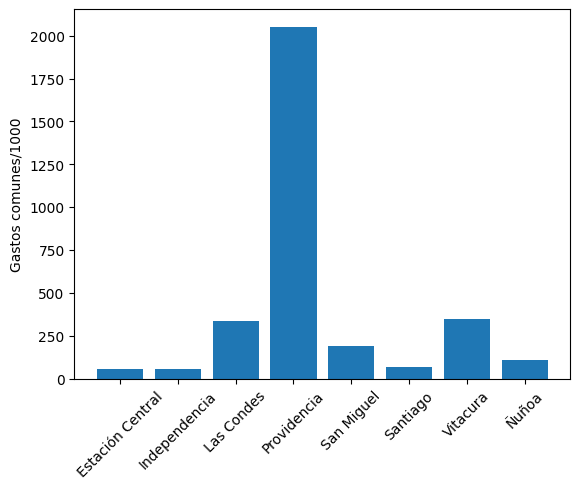

In [ ]:
import matplotlib.pyplot as plt
promedio_por_comuna = df2.groupby('Comuna')['Gastos_comunes'].mean().to_frame().reset_index()
plt.figure()
plt.bar(promedio_por_comuna['Comuna'], promedio_por_comuna['Gastos_comunes']/1000)
plt.ylabel('Gastos comunes/1000')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Algo no cuadra:
df2['Gastos_comunes'][df2['Comuna'] == 'Providencia'][lambda x:x>1000000]

8490    1.600000e+09
Name: Gastos_comunes, dtype: float64

In [ ]:
# Ahi esta el error, se excedieron en varios ceros.
df2.loc[8490]

Dirección                       Providencia, Carlos antunez  ricardo lyon
Precio_CLP                                                    327865142.0
Gastos_comunes                                               1600000000.0
Dormitorios                                                           3.0
Baños                                                                 3.0
Estacionamiento                                                        No
Superficie_total                                                    107.0
Superficie_útil                                                     100.0
Descripción             Estupendo departamento barrio residencial buen...
Fecha_de_publicación                                           2024-01-05
Agente_inmobiliario                                         No especifica
ID_de_publicación                                                29370184
Año_de_construcción                                                   NaN
Cocina                                

In [ ]:
df2.loc[8490, 'Gastos_comunes'] = 160000

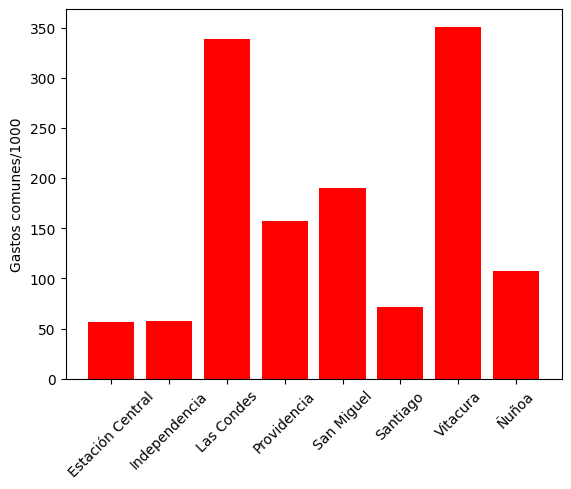

In [ ]:
promedio_por_comuna = df2.groupby('Comuna')['Gastos_comunes'].mean().to_frame().reset_index()
plt.figure()
plt.bar(promedio_por_comuna['Comuna'], promedio_por_comuna['Gastos_comunes']/1000, color = 'red')
plt.ylabel('Gastos comunes/1000')
plt.xticks(rotation=45)
plt.show()

In [ ]:
comunas=df2.Comuna.unique()
# Llenamos los valores nulos con el promedio por comuna:
for comuna in comunas:
    promedio = round(df2['Gastos_comunes'][df2.Comuna == 'Santiago'].mean())
    df2['Gastos_comunes'][(df2.Comuna == comuna) & (df2.Gastos_comunes.isna())] = promedio

In [ ]:
df3=df2.copy()
df3.columns

Index(['Dirección', 'Precio_CLP', 'Gastos_comunes', 'Dormitorios', 'Baños',
       'Estacionamiento', 'Superficie_total', 'Superficie_útil', 'Descripción',
       'Fecha_de_publicación', 'Agente_inmobiliario', 'ID_de_publicación',
       'Año_de_construcción', 'Cocina', 'Bodega', 'Piscina', 'Comuna', 'dir',
       'Año', 'Mes', 'Día'],
      dtype='object')

In [ ]:
df3.shape

(11238, 21)

<h3>Ahora filtramos algunos Datos.<h3/>

In [ ]:
import plotly.express as px

In [ ]:
FB=100000000
FM=1000000

In [ ]:
print(df3['Comuna'].value_counts())

Comuna
Santiago            4268
Las Condes          1684
Ñuñoa               1609
Providencia         1038
Estación Central     961
San Miguel           774
Independencia        469
Vitacura             435
Name: count, dtype: int64


In [ ]:
fig = px.box(df3, x="Comuna", y='Precio_CLP', points="all",
              color="Comuna")
fig.show()

In [ ]:
# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Santiago') & (df3['Precio_CLP'] >= (2*FB))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Las Condes') & (df3['Precio_CLP'] >= 10*FB)].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Providencia') & (df3['Precio_CLP'] >= (0.8*FB) )].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Providencia') & (df3['Precio_CLP'] >= (0.8*FB) )].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Estación Central') & (df3['Precio_CLP'] >= (2*FB) )].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)


# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'San Miguel') & (df3['Precio_CLP'] >= (350*FM) )].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Independencia') & (df3['Precio_CLP'] > (400000000) )].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Vitacura') & (df3['Precio_CLP'] >= (1600000000) )].index#
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

print(df3['Comuna'].value_counts())

Comuna
Santiago            4159
Las Condes          1641
Ñuñoa               1609
Estación Central     958
San Miguel           773
Independencia        469
Vitacura             431
Name: count, dtype: int64


In [ ]:
fig = px.box(df3, x="Comuna", y='Superficie_útil', points="all",
              color="Comuna")
fig.show()

In [ ]:
# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Santiago') & (df3['Superficie_útil'] >= (400))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Independencia') & (df3['Superficie_útil'] >= (300))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Ñuñoa') & (df3['Superficie_útil'] >= (200))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Estación Central') & (df3['Superficie_útil'] >= (190))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Vitacura') & (df3['Superficie_útil'] >= (500))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

print(df3['Comuna'].value_counts())

Comuna
Santiago            4158
Las Condes          1641
Ñuñoa               1607
Estación Central     957
San Miguel           773
Independencia        469
Vitacura             429
Name: count, dtype: int64


In [ ]:
fig = px.box(df3, x="Comuna", y='Gastos_comunes', points="all",
              color="Comuna")
fig.show()

In [ ]:
# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Las Condes') & (df3['Gastos_comunes'] >= (1.5*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'San Miguel') & (df3['Gastos_comunes'] >= (0.4*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Estación Central') & (df3['Gastos_comunes'] >= (0.2*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Ñuñoa') & (df3['Gastos_comunes'] >= (0.4*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Santiago') & (df3['Gastos_comunes'] >= (0.4*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Vitacura') & (df3['Gastos_comunes'] >= (1.4*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)
print(df3['Comuna'].value_counts())

Comuna
Santiago            4153
Las Condes          1637
Ñuñoa               1606
Estación Central     955
San Miguel           770
Independencia        469
Vitacura             428
Name: count, dtype: int64


In [ ]:
fig = px.box(df3, x="Comuna", y='Superficie_total', points="all",
              color="Comuna")
fig.show()

In [ ]:
# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'San Miguel') & (df3['Superficie_total'] >= (200))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Estación Central') & (df3['Superficie_total'] >= (155))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Ñuñoa') & (df3['Superficie_total'] >= (230))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Santiago') & (df3['Superficie_total'] >= (230))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Vitacura') & (df3['Superficie_total'] >= (580))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Independencia') & (df3['Superficie_total'] >= (200))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

#df5 = df5.drop(filas_a_eliminar)
print(df3['Comuna'].value_counts())

Comuna
Santiago            4149
Las Condes          1637
Ñuñoa               1604
Estación Central     952
San Miguel           767
Independencia        467
Vitacura             424
Name: count, dtype: int64


In [ ]:
df3.columns

Index(['Dirección', 'Precio_CLP', 'Gastos_comunes', 'Dormitorios', 'Baños',
       'Estacionamiento', 'Superficie_total', 'Superficie_útil', 'Descripción',
       'Fecha_de_publicación', 'Agente_inmobiliario', 'ID_de_publicación',
       'Año_de_construcción', 'Cocina', 'Bodega', 'Piscina', 'Comuna', 'dir',
       'Año', 'Mes', 'Día'],
      dtype='object')

In [ ]:
# Calcular el cociente y asignarlo a una nueva columna
df3['Precio_x_m2tot'] = df3['Precio_CLP'] / df3['Superficie_total']

# Calcular el cociente y asignarlo a una nueva columna
df3['Precio_x_m2util'] = df3['Precio_CLP'] / df3['Superficie_útil']

In [ ]:
fig = px.box(df3, x="Comuna", y='Precio_x_m2util', points="all",
              color="Comuna")
fig.show()

In [ ]:
# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'San Miguel') & (df3['Precio_x_m2util'] >= (20*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Estación Central') & (df3['Precio_x_m2util'] >= (20*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Ñuñoa') & (df3['Precio_x_m2util'] >= (60*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Independencia') & (df3['Precio_x_m2util'] >= (60*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Santiago') & (df3['Precio_x_m2util'] >= (60*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Vitacura') & (df3['Precio_x_m2util'] >= (0.2*FB))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

# Filtrar las filas que cumplan con las condiciones especificadas
filas_a_eliminar = df3[(df3['Comuna'] == 'Las Condes') & (df3['Precio_x_m2util'] >= (30*FM))].index
# Eliminar las filas que cumplen con las condiciones
df3 = df3.drop(filas_a_eliminar)

print(df3['Comuna'].value_counts())

Comuna
Santiago            4146
Las Condes          1635
Ñuñoa               1603
Estación Central     947
San Miguel           763
Independencia        466
Vitacura             422
Name: count, dtype: int64


Se borran aquellas filas que tengan menos de 10metros cuadrados totales y útiles.

In [ ]:
df3=df3[df3['Superficie_útil']>10]
df3=df3[df3['Superficie_total']>10]
print(df3['Comuna'].value_counts())

Comuna
Santiago            4059
Las Condes          1627
Ñuñoa               1575
Estación Central     929
San Miguel           756
Independencia        459
Vitacura             419
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Supongamos que tu DataFrame se llama df6 y la columna de fecha se llama 'Fecha_de_publicación'

# Convertir la columna de fecha a tipo datetime si aún no lo está
df3['Fecha_de_publicación'] = pd.to_datetime(df3['Fecha_de_publicación'])

# Modificar la columna de fecha para que solo muestre año y mes
df3['Fecha_de_publicación'] = df3['Fecha_de_publicación'].dt.to_period('M')

# Establecer una fecha límite máxima (por ejemplo, '2024-03')
fecha_limite = pd.Period('2024-03')

# Filtrar el DataFrame para eliminar las filas que estén después de la fecha límite máxima
df3 = df3[df3['Fecha_de_publicación'] <= fecha_limite]

# Verificar el DataFrame resultante
print(df3.head())

                                           Dirección   Precio_CLP  \
0  Santiago, Padre Miguel de Olivares / Metro Moneda   95780828.0   
1         Santiago, Lira 399, esquina Santa Victoria  128935730.0   
2                        Santiago, Lord Cochrane 298  119726035.0   
3                           Santiago, Av. España 397  162090632.0   
4                             Santiago, Portugal 333  121567974.0   

   Gastos_comunes  Dormitorios  Baños Estacionamiento  Superficie_total  \
0         70000.0          2.0    1.0              No              48.0   
1         98000.0          2.0    2.0              Si              50.0   
2        100000.0          2.0    2.0              Si              52.0   
3        100000.0          3.0    2.0              Si              72.0   
4         50000.0          3.0    2.0              No              90.3   

   Superficie_útil                                        Descripción  \
0             48.0   Arriendo Departamento Estilo Mariposa  L

In [ ]:
df4=df3.copy()

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9824 entries, 0 to 12142
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype    
---  ------                --------------  -----    
 0   Dirección             9824 non-null   object   
 1   Precio_CLP            9824 non-null   float64  
 2   Gastos_comunes        9824 non-null   float64  
 3   Dormitorios           9824 non-null   float64  
 4   Baños                 9824 non-null   float64  
 5   Estacionamiento       9824 non-null   object   
 6   Superficie_total      9824 non-null   float64  
 7   Superficie_útil       9824 non-null   float64  
 8   Descripción           9824 non-null   object   
 9   Fecha_de_publicación  9824 non-null   period[M]
 10  Agente_inmobiliario   9824 non-null   object   
 11  ID_de_publicación     9824 non-null   int64    
 12  Año_de_construcción   3118 non-null   float64  
 13  Cocina                9824 non-null   object   
 14  Bodega                9824 non-null   object

In [ ]:
df4['Dormitorios'] = df4['Dormitorios'].astype('object')
df4['Baños'] = df4['Baños'].astype('object')

In [ ]:
df4 =  df4.drop(['Descripción', 'Dirección','ID_de_publicación'], axis = 1)

In [ ]:
df4.columns

Index(['Precio_CLP', 'Gastos_comunes', 'Dormitorios', 'Baños',
       'Estacionamiento', 'Superficie_total', 'Superficie_útil',
       'Fecha_de_publicación', 'Agente_inmobiliario', 'Año_de_construcción',
       'Cocina', 'Bodega', 'Piscina', 'Comuna', 'dir', 'Año', 'Mes', 'Día',
       'Precio_x_m2tot', 'Precio_x_m2util'],
      dtype='object')

In [ ]:
# Suponiendo que 'df' es tu DataFrame y 'nuevo_orden' es la lista que contiene el nuevo orden de las columnas
nuevo_orden = ['Comuna','dir' ,'Precio_CLP', 'Gastos_comunes','Superficie_total', 'Superficie_útil',
               'Precio_x_m2tot', 'Precio_x_m2util',
               'Año_de_construcción',
               'Fecha_de_publicación','Año', 'Mes', 'Día',
               'Dormitorios', 'Baños','Estacionamiento',
               'Cocina', 'Bodega', 'Piscina', 'Agente_inmobiliario',

               ]  # Especifica el nuevo orden de las columnas

# Reorganiza el orden de las columnas seleccionándolas en el nuevo orden
df4 = df4[nuevo_orden]

Este es la base de datos para el dashboard. Para el Machine learning se eliminan otras columnas.

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9824 entries, 0 to 12142
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype    
---  ------                --------------  -----    
 0   Comuna                9824 non-null   object   
 1   dir                   9824 non-null   object   
 2   Precio_CLP            9824 non-null   float64  
 3   Gastos_comunes        9824 non-null   float64  
 4   Superficie_total      9824 non-null   float64  
 5   Superficie_útil       9824 non-null   float64  
 6   Precio_x_m2tot        9824 non-null   float64  
 7   Precio_x_m2util       9824 non-null   float64  
 8   Año_de_construcción   3118 non-null   float64  
 9   Fecha_de_publicación  9824 non-null   period[M]
 10  Año                   9824 non-null   int64    
 11  Mes                   9824 non-null   int64    
 12  Día                   9824 non-null   int64    
 13  Dormitorios           9824 non-null   object   
 14  Baños                 9824 non-null   object

Este data frame se usa para la graficación, luego para el machine learning se pueden eliminar otras columnas.

In [ ]:
# Especificar la ruta donde deseas guardar el archivo CSV
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/VentaDpto_StgoChile/Departamentos_Chile/Datacleaning/DeptoChile_DB.csv'

# Guardar el DataFrame como un archivo CSV
df4.to_csv(ruta_archivo, index=False)

In [ ]:
df4.shape

(9824, 20)

<h3>Eliminamos otras columnas para el ML.<h3/>

In [ ]:
# Para un pirmer test vamos a considerar el promedio para rellenar los valores faltantes
df4['Año_de_construcción'] = df4['Año_de_construcción'].fillna(round(df4['Año_de_construcción'].mean()))

# Fechas de construcción:
df4 = df4.drop(df4['Año_de_construcción'][lambda x: x>2024].index)
df4 = df4.drop(df4['Año_de_construcción'][lambda x: x<1940].index)

In [ ]:
df4 =  df4.drop(['Fecha_de_publicación','Año',
                 'Día','Mes','Precio_x_m2tot','Precio_x_m2util'], axis = 1)

In [ ]:
df4.shape

(9813, 14)

In [ ]:
# Especificar la ruta donde deseas guardar el archivo CSV
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/VentaDpto_StgoChile/Departamentos_Chile/Datacleaning/DeptoChile_DB_ML.csv'

# Guardar el DataFrame como un archivo CSV
df4.to_csv(ruta_archivo, index=False)

In [ ]:
df4.columns

Index(['Comuna', 'dir', 'Precio_CLP', 'Gastos_comunes', 'Superficie_total',
       'Superficie_útil', 'Año_de_construcción', 'Dormitorios', 'Baños',
       'Estacionamiento', 'Cocina', 'Bodega', 'Piscina',
       'Agente_inmobiliario'],
      dtype='object')